# Data wrangling submission

The goal of this submission is to choose an area of the world in https://www.openstreetmap.org, assess the quality of data for validity, accuracy, completeness, consistency and uniformity, clean it, and import to MongoDB. 

A custom Sydney area was selected on and downloaded as OSM XML from [Mapzen](https://mapzen.com/) to perform the exercise. The file structure is described in the [relevant openstreetmap wiki](https://wiki.openstreetmap.org/wiki/OSM_XML). 

## Auditing the data 

First, let's open the file and analyse how many different element types are in there. Parcing with ElementTree should be used since the dataset is quite large for processing in memory. 

In [269]:
import xml.etree.cElementTree as ET
import pprint

filename='sydney.osm'

tags = {}

for event, elem in ET.iterparse(filename):  
    if elem.tag in tags: 
        tags[elem.tag] += 1
    else:                
        tags[elem.tag] = 1

pprint.pprint(tags)  

{'bounds': 1,
 'member': 25877,
 'nd': 356990,
 'node': 279383,
 'osm': 1,
 'relation': 2020,
 'tag': 242420,
 'way': 50169}


As expected, there are a lot of nodes and tags which we will have to analyse. 

As the data will be eventually loaded in MongoDB, we need to ensure that there are no problematic characters that cannot be used within keys in MongoDB. In other words, for tags: 

we should check key values for problematic characters. Also, let's see how many tag keys contain colons (such as addr:street).  

In [270]:
# Regular expressions module
import re

# Expression to detect problematic characters, characters in lowercase without and with colon 
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        check_k = element.attrib['k']
        if re.search(lower, check_k): 
            keys['lower'] += 1     
        elif re.search(lower_colon, check_k): 
            keys['lower_colon'] += 1        
        elif re.search(problemchars, check_k): 
            print "Problematic key: '", check_k, "', value ", element.attrib['v']
            keys['problemchars'] += 1        
        else:
            keys['other'] += 1
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        # _ is a throwaway value here 
        keys = key_type(element, keys)
    return keys

process_map(filename)

Problematic key: ' Payments Accepted ', value  Cash, Credit Card, Invoice
Problematic key: ' old Fox Name ', value  007: License To Thrill
Problematic key: ' Old Fox Name ', value  Star Dressing Room


{'lower': 202807, 'lower_colon': 37014, 'other': 2596, 'problemchars': 3}

We will ignore the 'old fox name' tags because their values do not really represent old names of the places, and we will change the tag 'Payments Accepted' to the key 'payment:credit_cards' with value 'yes' as specified in the OSM Wiki. We will ignore the cash and invoice values because the ability to pay with a credit card is a key information in this case. 

In [271]:
# Create a function to process the problematic payments tag for future reference
def process_bad_payment(t_key, t_val): 
    if (t_key.lower().find('payment') >= 0):
        t_key = "payment:credit_cards"
        t_val = "yes"
    return t_key, t_val

### Street names and types

As the data has been added by people, we should expect variations in how streets are called and abbreviated. Indeed, this was evident to me when I used OpenStreetView-based apps for navigation. An example of tags which should be checked and cleaned is: tag k="addr:street" v="Missenden Str."

We will do the following to analyse how the streets names are written and to clean the data: 
1. Parse through the file, searching for tags with attribute k having value "addr:street".
2. Create a dictionary with all possible endings in the street names.
3. Create a mapping to make the abbreviations consistent and update the data. 


In [272]:
# Using defaultdict to allow for default (zero) values 
from collections import defaultdict

# Sequence of non-whitespace characters \S+ optionally followed by period (to catch st./sqr./etc.), 
# which should appear in the string ending ($)
street_type_re = re.compile(r'\S+\.?$', re.IGNORECASE)

# For int, the default value is zero. A defaultdict will never raise a KeyError. 

street_types = defaultdict(int)

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        street_types[street_type] += 1

def print_sorted_dict(d):
    keys = d.keys()
    # Sort the keys alphabetically independently from upper/lower case
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print "%s: %d" % (k, v) 

def is_street_name(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] == "addr:street")

def audit(filename):
    for event, elem in ET.iterparse(filename):
        # If this is a tag with street name
        if is_street_name(elem):
            # Update the counter for the corresponding street type 
            audit_street_type(street_types, elem.attrib['v'])    
    print_sorted_dict(street_types)    

# Running the main function on our dataset
s_types = audit(filename)
pprint.pprint(s_types)  

2000澳洲: 1
2026澳洲: 1
?: 1
Adventure: 1
Androtis: 1
Arcade: 1
Avenue: 301
Berith: 25
Boulevard: 4
Boulevarde: 4
Broadway: 25
Circuit: 9
City: 1
Crescent: 22
Drive: 21
Edward: 5
Esplanade: 8
Fitzroy: 1
Gardens: 14
Head: 1
Highway: 60
Jones: 1
Lane: 61
Leichhardt: 1
Market: 3
marrickville: 1
North: 1
Offramp: 1
Parade: 92
Place: 46
Plaza: 1
Point: 2
Promanade: 1
Road: 1069
Shaw: 3
South: 1
Square: 2
St: 12
St.: 1
street: 4
Street: 3502
Street): 1
Sydney: 1
Terrace: 2
underpass: 1
Wales: 1
Way: 3
West: 1
Wolli: 74
Wollit: 1
None


This looks like a mess - some names figure zip codes, chinese symbols, and suburbs. For some results, transformation is already clear, whereas for other we should look at values to understand what is the content. Let's take a closer look by defining a list with expected street names ending and by modifying the audit_street_type function to include full values with unexpected endings. 

In [273]:
# List with expected names
expected = ["Avenue", "Boulevard", "Broadway", "Circuit", "Crescent", "Terrace", "Way", 
            "Drive", "Highway", "Lane", "Parade", "Place", "Road", "Street", "Square", 
            "Gardens", "Point"]

street_types = defaultdict(set)
    
# Let's change our function to addy full values for unexpected street names 
def audit_street_type(street_types, street_name):
    # Use the regular expression defined previously
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

# And rewrite the audit function so it returns street types
def audit(filename):
    for event, elem in ET.iterparse(filename):
        # If this is a tag with street name
        if is_street_name(elem):
            # Update the counter for the corresponding street type 
            audit_street_type(street_types, elem.attrib['v'])    
    return street_types   
        
# Running the main function on our dataset
st_types = audit(filename)
pprint.pprint(dict(st_types)) 

{u'2000\u6fb3\u6d32': set([u'Playfair St & Argyle Street, The Rocks NSW 2000\u6fb3\u6d32']),
 u'2026\u6fb3\u6d32': set([u'70A Campbell Parade, Bondi Beach NSW 2026\u6fb3\u6d32']),
 '?': set(['?']),
 'Adventure': set(['Victoria Adventure']),
 'Androtis': set(['Androtis']),
 'Arcade': set(['Tramway Arcade']),
 'Berith': set(['Berith']),
 'Boulevarde': set(['The Boulevarde']),
 'City': set(['City']),
 'Edward': set(['Edward']),
 'Esplanade': set(['The Esplanade']),
 'Fitzroy': set(['Fitzroy']),
 'Head': set(['Henry Head']),
 'Jones': set(['Jones']),
 'Leichhardt': set(['Leichhardt']),
 'Market': set(['Sydney Fish Market']),
 'North': set(['Ocean Street North']),
 'Offramp': set(['King Street Offramp']),
 'Plaza': set(['Elizabeth Plaza']),
 'Promanade': set(['The Promanade']),
 'Shaw': set(['Shaw']),
 'South': set(['Alfred Street South']),
 'St': set(['2 Lackey St',
            '360 Victoria St',
            'Cnr / Playfair & Argyle St',
            'Comer St',
            'Henderson St',


Except for abbreviations which we could clearly map to correct naming, there are some peculiarities: 
1. There are clarifications in parenthesis which should be removed from the name. 
2. There are non-English and non-alphanumeric symbols which should be removed (except for '&' which is a valid symbol).  
3. If there is one comma in the street name, we should only keep value before the comma (e.g. "Playfair St & Argyle Street, The Rocks NSW 2000" should be transformed into "Playfair St & Argyle Street"). 
4. If there are two commas (or more) in the street name, we should only keep value after the first and before the second comma (e.g. "The Wharf, Cowper Wharf Road, Woolloomooloo, Sydney" should be "Cowper Wharf Road". 
5. In a few cases, 'Street' shoud be added to the name - this includes the following values: Berit, Edward, Fitzroy, Jones, Shaw, Wolli. 
6. Finally, 'King Street Offramp' should be transformed to 'King Street', 'Pacific Highway underpass' should be 'Pacific Highway', and 'nr East Street' should be just 'East Street' (there is no North East Street in Marickville). 

Notably, some street names are valid while being unusual - this includes: 
- Tramway Arcade
- The Boulevarde
- The Esplanade
- Ocean Street North
- Elizabeth Plaza
- The Promanade
- Alfred Street South

Now, let's update the expected list, address points 1-6, and create a function to transform abbreviations via mapping. We will delete values if mapping cannot be done. 

In [274]:
# Updated list with expected names
expected = ["Avenue", "Boulevard", "Broadway", "Circuit", "Crescent", "Terrace", "Way", 
            "Drive", "Highway", "Lane", "Parade", "Place", "Road", "Street", "Square", 
            "Gardens", "Point", 
            "Arcade", "Boulevarde", "Esplanade", "North", "Plaza", "Promanade", "South"
           ]

# Dictionary with mapping 
mapping = { "street": "Street", 
            "St.": "Street", 
            "St": "Street"
            }

# P.5: For these names, 'Street' should be added
add_street = ["Berit", "Edward", "Fitzroy", "Jones", "Shaw", "Wolli"]

def name_clean(name): 
    # Capitalise the first letter 
    name = name[:1].upper() + name[1:]
    # P.1: If there is parenthesis - return the part before parenthesis
    name = re.sub(r'\s\([^)]*\)', '', name)
    # P.2: Remove non-English and non-alphanumeric excluding '&' symbol, commas, and spaces (\s)
    name = re.sub('[^0-9a-zA-Z&,\s]+', '', name)
    # P.3: If there is one comma, return symbols before the comma
    name_split = name.split(',')
    if len(name_split) == 2: name = name_split[0].strip()
    # P.4: If there are two commas or more, return value after first and before second
    if len(name_split) > 2: name = name_split[1].strip()
    # Removing all excess whitespaces 
    name = ' '.join(name.split())
    return name

def name_corr(name):
    # P.6: Handling specific cases
    if name == "King Street Offramp": name = "King Street"
    if name == "Pacific Highway underpass": name = "Pacific Highway"
    if name == "nr East street": name = "East Street"
    # P.5: Adding 'Street' where required 
    if name in add_street: 
        return name + " Street"
    else: 
        return name

# After performing name_clean and name_corr, we should check if street name is in expected
# If not - map; we will return None if mapping cannot be done 
def name_map(name, mapping):
    m = street_type_re.search(name)
    if m:
        street_type = m.group()     
        if street_type in expected: 
            return name
        else: 
            if street_type in mapping:
                name = name.replace(street_type, mapping[street_type])          
            else: 
                name = None
    else: 
        name = None        
    return name 

# Combine all the functions
def process_st_name(name):
    name = name_clean(name)
    name = name_corr(name)
    name = name_map(name, mapping)  
    return name 

# Interating through s_types which we creaated previously to check the outcome
for st_type, ways in st_types.iteritems():
    for name in ways:
        print name, "=>", process_st_name(name)

City => None
Addison road, nr East street, marrickville => East Street
Shaw => Shaw Street
Tramway Arcade => Tramway Arcade
Wollit => None
Lyons Road West => None
Phillip St. => Phillip Street
Chalmers street => Chalmers Street
Plowman street => Plowman Street
George street => George Street
george street => George Street
The Wharf, Cowper Wharf Road, Woolloomooloo, Sydney => Cowper Wharf Road
New South Wales => None
The Promanade => The Promanade
Henry Head => None
Pacific Highway underpass => Pacific Highway
Fitzroy => Fitzroy Street
70A Campbell Parade, Bondi Beach NSW 2026澳洲 => 70A Campbell Parade
Holt Street (enter via Gladstone Street) => Holt Street
Victoria Adventure => None
? => None
Jones => Jones Street
King Street Offramp => King Street
Elizabeth Plaza => Elizabeth Plaza
Liverpool St => Liverpool Street
Henderson St => Henderson Street
Phillips St => Phillips Street
Comer St => Comer Street
Lackey St => Lackey Street
2 Lackey St => 2 Lackey Street
Kenwyn St => Kenwyn Street


Looks good! We can use this function for further processing. Although it was written based on analysis of one specific area, it can be used for cleaning other areas as well. However, we would have to analyse all the peculiarities for a new area which are not fixed by the points considered above. People are generally creative - so, no one knows what to expect. 

Also, let's use %timeit function to check how long would it take to run process_st_name for each street name. 

In [275]:
%timeit process_st_name(name)

100000 loops, best of 3: 14 µs per loop


### Maximum speed values

Another point which I noticed was that maximum speed values were incorrect several times when I tried using OpenStreetView-based apps. As per wiki, maximum speed values are specified in the [maxspeed tag](http://wiki.openstreetmap.org/wiki/Key:maxspeed). 
Let's examine possible values in our dataset:   

In [276]:
# Create an empty list for further cleaning
speeds_to_clean = []

def is_speed(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] == "maxspeed")

# Checking the values. Speeds between 5-120 are valid, and 'signals' is a valid value too
def audit_speeds(filename):
    for event, elem in ET.iterparse(filename):
        if is_speed(elem):
            try: 
                speedval = int(elem.attrib['v'])
                # Print value if it is below 5 or above 120 kmph
                if (int(speedval) < 5) or (int(speedval) > 120): 
                    print "Too low/high: ", speedval 
                    speeds_to_clean.append(speedval)
            except ValueError: 
                # Non-numeric value
                if elem.attrib['v'] != 'signals': 
                    print "Non-numeric value: ", elem.attrib['v']
                    speeds_to_clean.append(elem.attrib['v'])

# Analyse the dataset
speed_analysis = audit_speeds(filename)

Non-numeric value:  40 mph
Non-numeric value:  50 mph
Non-numeric value:  30 mph
Non-numeric value:  sign
Non-numeric value:  sign
Non-numeric value:  10;10 mph
Non-numeric value:  10 mph
Too low/high:  0


There are just a few minor issues: 
1. Mph is not correct because speed in Australia is measured in kmph, and the speed values above are really in kmph rather than mph. So, we should just delete 'mph' from the values. 
2. 'Sign' should be replaced to 'signals' to be consistent with other records. 
3. '10;10' should be changed to 10. 
4. 0 should be changed to None. 

Let's fix this: 

In [295]:
# Function to correct speeds
def process_speed(speed): 
    try: 
        # P.4 - zeros should be changed to None 
        speed = int(speed)
        if speed == 0: speed = None
    except ValueError: 
        # P.1 - remove 'mph'
        speed = speed.replace(' mph','')
        # Try to convert to int again 
        try: 
            speed = int(speed)
        except ValueError: 
            # Handling P.2 & P.3
            if (speed == 'sign') or (speed == 'sign'): 
                speed = 'signals'
            elif speed == '10;10': 
                speed = 10
            else: 
                speed = None
    return speed

# Try on problematic values 
for speed in speeds_to_clean: 
    print speed, "=>", process_speed(speed)

40 mph => 40
50 mph => 50
30 mph => 30
sign => signals
sign => signals
10;10 mph => 10
10 mph => 10
0 => None


Similarly, let's see how fast this function is: 

In [278]:
%timeit process_speed(speed)

The slowest run took 8.73 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 329 ns per loop


### Cycleways

One more point I would like to look at is cycleway tags. As a cyclist who uses Bike Maps and similar applications, I had been consistently disappointed in the quality of routes which I was routed to by these apps. For example, I noticed that some dedicated or joint cycleway had never popped up - instead, apps showed routes through usual roads making my trips less pleasant. 

By reading OSM wiki, I have figured out that the relevant tags are ["cycleway"](http://wiki.openstreetmap.org/wiki/Key:cycleway) and ["bicycle"](http://wiki.openstreetmap.org/wiki/Bicycle). Wiki also includes recommended tag values and statistics on their use. This information would be handy to create lists of expected values. Now, let's analyse the data.  

In [279]:
# Possible tags are cycleway, cycleway:right, cycleway:left
cycleway_tags = ['cycleway', 'cycleway:left', 'cycleway:right']

# Tags and expected values for bicycle and cycleway tags as specified on OSM Wiki
cycleway_expected = ['lane', 'opposite_lane', 'opposite', 'shared_lane', 'share_busway', 'shared', 
                     'track', 'opposite_track', 'asl', 'shoulder', 'separate', 'no', 'yes', 
                     'right', 'crossing', 'segregated', 'none', 'sidepath', 'both', 'unmarked_lane', 
                     'left'] 
bicycle_expected = ['yes', 'no', 'designated', 'use_sidepath', 'permissive','destination', 'dismount']

# A dictionary to check unexpected values and their frequency
cycleway_unexp = defaultdict(int)
bicycle_unexp = defaultdict(int)

def is_cycleway(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] in cycleway_tags)

def is_bicycle(elem): 
    return (elem.tag == "tag") and (elem.attrib['k'] == "bicycle")

# Checking the values. Speeds between 5-120 are valid, and 'signals' is a valid value too
def audit_cycleways(filename):
    for event, elem in ET.iterparse(filename):
        if is_cycleway(elem): 
            if elem.attrib['v'] not in cycleway_expected:
                cycleway_unexp[elem.attrib['v']] += 1
        if is_bicycle(elem): 
            if elem.attrib['v'] not in bicycle_expected:
                bicycle_unexp[elem.attrib['v']] += 1
                
# Analyse the dataset
audit_cycleways(filename)
print "Unexpected cycleway tag values:"
pprint.pprint(dict(cycleway_unexp))
print "Unexpected bicycle tag values:"
pprint.pprint(dict(bicycle_unexp))

Unexpected cycleway tag values:
{'?dismount': 1,
 'designated': 3,
 'designated; track': 2,
 'dismount': 1,
 'doorzone': 2,
 'parallel': 7}
Unexpected bicycle tag values:
{'designated;yes': 1,
 'designated||': 9,
 'private': 3,
 'proposed': 5,
 'stupid': 13,
 'survey required': 14,
 'unsurveyed': 2,
 'y': 1,
 'yes;dismount': 1,
 '|designated|||': 1,
 '|designated||||': 1,
 '||designated|||': 1}


In fact, both tags can have user-defined values as wiki only recommends values rather than prescribes them. However, some of these tags definitely require cleaning. Let's clean the values using common sense. In fact, one universal function can be created for both tag values. 

In [280]:
# Create a joint cycleways / bicycle tags list for future reference 
bicycle_way_tags = ['cycleway', 'cycleway:left', 'cycleway:right', 'bicycle']

def process_bicycle(name): 
    # If there is semicolon - return the part before it
    name = name.split(";")[0]
    # Remove non-English and non-alphanumeric
    name = re.sub('[^0-9a-zA-Z]+', '', name)
    # Other improvements 
    if name == 'y': name = 'yes'
    if name == 'stupid': name = 'yes'
    return name 

print "Cycleway tag values"
for element in cycleway_unexp:
    print element, "=>", process_bicycle(element)

print "\nBicycle tag values"
for element in bicycle_unexp:
    print element, "=>", process_bicycle(element)

Cycleway tag values
?dismount => dismount
doorzone => doorzone
designated => designated
dismount => dismount
designated; track => designated
parallel => parallel

Bicycle tag values
survey required => surveyrequired
proposed => proposed
yes;dismount => yes
||designated||| => designated
private => private
unsurveyed => unsurveyed
stupid => yes
designated;yes => designated
y => yes
designated|| => designated
|designated||| => designated
|designated|||| => designated


Use %timeit again to check the speed: 

In [281]:
%timeit process_bicycle('name')

The slowest run took 4.42 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.97 µs per loop


All right, let's move on. 

## Preparation for MongoDB

In order to import data to MongoDB, we will need to transform it to csv, tsv, or json file. Let's create json as it is the most appropriate default import format. 

We will parse through the file, returning dictionaries for 'nodes' and 'ways' using the following logic:

### If the element top level tag is "node"
The dictionary returned should have the format {"type" : "node", "node": .., "node_tags": ...}. The "node" field should hold a dictionary of the following top level node attributes: id, user, uid, version, lat, lon, timestamp, changeset. All other attributes will be ignored. 

The "node_tags" field should hold a list of dictionaries, one per secondary tag. Secondary tags are child tags of node which have the tag name/type: "tag". Each dictionary should have the following fields from the secondary tag attributes:
- id: the top level node id attribute value
- key: the full tag "k" attribute value if no colon is present or the characters after the colon if one is.
- value: the tag "v" attribute value
- type: either the characters before the colon in the tag "k" value or "regular" if a colon is not present.

Additionally,
- if a node has no secondary tags then the "node_tags" field should just contain an empty list.
- if the tag "k" value contains problematic characters, the tag should be ignored
- if the tag "k" value contains a ":" the characters before the ":" should be set as the tag type
  and characters after the ":" should be set as the tag key
- if there are additional ":" in the "k" value they and they should be ignored and kept as part of
  the tag key. For example:

will be turned into

### If the element top level tag is "way":
The dictionary should have the format {"type" : "way", "way": ..., "way_tags": ..., "way_nodes": ...}. The "way" field should hold a dictionary of the following top level way attributes: id, user, uid, version, timestamp, changeset. 

All other attributes will be ignored

The "way_tags" field should hold a list of dictionaries, following the exact same rules as for "node_tags".

Additionally, the dictionary should have a field "way_nodes". "way_nodes" should hold a list of
dictionaries, one for each nd child tag.  Each dictionary should have the fields:
- id: the top level element (way) id
- node_id: the ref attribute value of the nd tag
- position: the index starting at 0 of the nd tag i.e. what order the nd tag appears within the way element

### The approach to processing the osm file 

We will define a function shape_element that processes each element from the OSM XML. Within this function, all the above-stated rules will be applied.

In [282]:
# Import libraries which will be necessary to perform transformations 
import string 
from datetime import datetime

# Fields which will be processed
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

# Function to process tags
def process_tag(tag, id_input): 
    tag_dict = {}

    # Working with tags 
    tag_val = tag.attrib['v']
    tag_key = tag.attrib['k']
    
    # Correct street names 
    if tag_key == "addr:street": 
        tag_val = process_st_name(tag_val)   
    # Correct maximum speed values 
    if tag_key == "maxspeed": 
        tag_val = process_speed(tag_val)
    # Correct bicycle-related tags
    if (tag_key in bicycle_way_tags): 
        tag_val = process_bicycle(tag_val)  
 
    # Filling tag dictionary 
    tag_dict['id'] = id_input
    tag_dict['value'] = tag_val  
    
    # If there are no problem chars 
    if not re.search(problemchars, tag_key): 
        key_split = tag_key.split(':',1)   # to split keys    
        if key_split[0] == tag_key: 
            tag_dict['key'] = tag_key
            tag_dict['type'] = 'regular' 
        else: 
            tag_dict['key'] = key_split[1] 
            tag_dict['type'] = key_split[0]   
    # If there are problem chars - check if this is a payments tag and process accordingly
    else: 
        tag_key_corr, tag_val_corr = process_bad_payment(tag_key, tag_val)
        if tag_key_corr != tag_key: 
            tag_dict['key'] = tag_key_corr
            tag_dict['value'] = tag_val_corr  
            tag_dict['type'] = 'regular'   
    return tag_dict

# Function to clean and shape node or way XML element to Python dict
def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=problemchars, default_tag_type='regular'):

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements
                    
    # Filling values for 'node'
    if element.tag == 'node':
        node_id = element.attrib['id']
        for field_e in NODE_FIELDS: 
            # Fixing timestamp
            if field_e == 'timestamp':
                node_attribs[field_e] = datetime.strptime(element.attrib[field_e], '%Y-%m-%dT%H:%M:%SZ')
            else:
                node_attribs[field_e] = element.attrib[field_e]
            
        for tag in element.iter("tag"):
            tag_dict = process_tag(tag, node_id)
            tags.append(tag_dict)

    # Filling values for 'way'
    if element.tag == 'way':
        way_id = element.attrib['id']
        for field_e in WAY_FIELDS: 
            if field_e == 'timestamp':
                way_attribs[field_e] = datetime.strptime(element.attrib[field_e], '%Y-%m-%dT%H:%M:%SZ')
            else:
                way_attribs[field_e] = element.attrib[field_e]
            
        count = 0 
        for nd in element.iter("nd"): 
            way_nodes_dict = {}
            way_nodes_dict['id'] = way_id
            way_nodes_dict['node_id'] = nd.attrib['ref']
            way_nodes_dict['position'] = count
            way_nodes.append(way_nodes_dict) 
            count+=1
        for tag in element.iter("tag"):
            tag_dict = process_tag(tag, way_id)
            tags.append(tag_dict)
    
    if element.tag == 'node':
        return {'type' : 'node', 'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        return {'type' : 'way', 'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

Now we will parse the XML, shape the elements, and write to a json file. 

In [283]:
import json  
# BSON will be used for compatibility 
from bson import json_util

# Iteratively process each XML element 
def process_map(file_in, pretty = False):  
    file_out = "{0}.json".format(file_in)
    with open(file_out, "wb") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                fo.write(json.dumps(el, default=json_util.default) + "\n")

# Using time function to check the execution time 
import time
start_time = time.time()
                
# Now process elements
process_map(filename)  

# Printing the execution time 
print("Execution time: %s seconds" % (time.time() - start_time))

Execution time: 30.745000124 seconds


## Overview of the data 

Let's get an overview on the source OSM XML file and on the generated JSON. 

In [284]:
import os 
# Convert from bytes to megabytes and show two decimal points only 
print 'The source XML size: {:0.2f} MB'.format(os.path.getsize(filename)/1.0e6) 
print 'Produced JSON file: {:0.2f} MB'.format(os.path.getsize(filename + ".json")/1.0e6)

The source XML size: 68.83 MB
Produced JSON file: 112.32 MB


### Importing to with MongoDB

We will use the produced JSON file to perform import. I have installed a local instance of MongoDB, and added the MongoDB folder in the PATH Windows environment. By examining [MongoDB python client manual](https://docs.mongodb.com/getting-started/python/client/) and [this Stackoverflow post](https://stackoverflow.com/questions/4760215/running-shell-command-from-python-and-capturing-the-output) explaining the subprocess library, we can write some more code to import files from Python.

In [285]:
import signal  
import subprocess
from pymongo import MongoClient

db_name = 'openstreetmap'

# Connect to Mongo DB
client = MongoClient('localhost:27017')  
# Database 'openstreetmap' will be created if it does not exist
db = client[db_name]  

# Preparing for mongoimport
collection = filename[:filename.find('.')]  # name before the file extention

workdir = "D:\Data_science\Nanodegree\\4.Data_wrangling\Submission\\"
json_file = filename + '.json'

# Command for importing 
mongoimport_cmd = 'mongoimport -h 127.0.0.1:27017 ' + \
                  '--db ' + db_name + \
                  ' --collection ' + collection + \
                  ' --file ' + workdir + json_file

if collection in db.collection_names():  
    print 'Dropping collection: ' + collection
    db[collection].drop()

print "Executing: ", mongoimport_cmd
subprocess.call(mongoimport_cmd.split())  

Dropping collection: sydney
Executing:  mongoimport -h 127.0.0.1:27017 --db openstreetmap --collection sydney --file D:\Data_science\Nanodegree\4.Data_wrangling\Submission\sydney.osm.json


0

### Examining the data

The mongoimport command was executed successfully - now we can connect to the database and perform a statistical overview of the dataset. 

In [286]:
sydney_db = db[collection]  

First, let's check the number of created documents: 

In [287]:
docnum = sydney_db.find().count()  
print "Number of documents:", docnum

Number of documents: 329552


Now, let's calculate the number of unique users. First, let's do this separately for nodes and ways with the help of aggregation framework: 

In [288]:
# Create a function to return results of the cursor execution
def agg_pipeline(db, pipeline):
    return [doc for doc in sydney_db.aggregate(pipeline)]

# Create a pipeline for nodes and ways 
for elem_type in ['node', 'way']: 
    pipeline = [{"$match" : {'type': elem_type}}, 
                { "$group" : { "_id" : "$"+elem_type+".uid","count" : { "$sum" : 1}}}, 
                { "$group" : { "_id" : "unique"+elem_type+"users", "count" : { "$sum" : 1}}}
                ] 
    results = agg_pipeline(sydney_db, pipeline)
    print elem_type, ":", results 

node : [{u'count': 1036, u'_id': u'uniquenodeusers'}]
way : [{u'count': 724, u'_id': u'uniquewayusers'}]


Actually, if we stored the uid on the 'parent' level of each document, we would be able to check unique users in both using just one db request. Since we have user ids stored within 'way' and 'node' elements, we will have to calculate this by two stages: 

In [289]:
# Create a list because we need unique values only
unique_users = set()

for elem_type in ['node', 'way']: 
    # Finding all the records of each type 
    results = sydney_db.find({"type":elem_type})
    for elem in results:
        # Adding unique uid's to the set
        unique_users.add(elem[elem_type]['uid'])   
    
print "The number of unique users:", len(unique_users)

The number of unique users: 1156


As a cyclist, I am curious to see how many bicycle pumps and bicycle parkings are installed in the area. In the current structure, values 'bicycle_pump' and 'bicycle_parking' could be found in node_tags - value. Let's see: 

In [290]:
pipeline = [{"$match": {"type": "node", "node_tags.value": "bicycle_pump"}}, 
            {"$group" : { "_id" : "Bicycle pumps","count" : { "$sum" : 1}}}
           ]

print "Bicycle pumps:", agg_pipeline(sydney_db, pipeline)[0]['count']

pipeline = [{"$match": {"type": "node", "node_tags.value": "bicycle_parking"}}, 
            {"$group" : { "_id" : "Bicycle parkings","count" : { "$sum" : 1}}}
           ]

print "Bicycle parking:", agg_pipeline(sydney_db, pipeline)[0]['count']

Bicycle pumps: 2
Bicycle parking: 361


Well, there are not many pumps, but at least enough parking. 

In [291]:
# Three most referenced nodes 
pipeline = [{"$match": {"type": "way"}}, 
            {"$unwind": "$way_nodes"},
            {"$group" : { "_id" : "$way_nodes.node_id","count" : { "$sum" : 1}}}, 
            {"$sort": {"count": -1}},
            {"$limit": 3}
           ]

# Getting 3 most referenced nodes 
ref_nodes = agg_pipeline(sydney_db, pipeline)
# Printing every node
for node in ref_nodes: 
    pprint.pprint(sydney_db.find({'node.id': node['_id']})[0])

{u'_id': ObjectId('5935340956d783ab5dc244fc'),
 u'node': {u'changeset': u'37450437',
           u'id': u'4027062082',
           u'lat': u'-33.8833574',
           u'lon': u'151.206954',
           u'timestamp': datetime.datetime(2016, 2, 26, 1, 29, 55),
           u'uid': u'39288',
           u'user': u'rolandmwagner',
           u'version': u'1'},
 u'node_tags': [],
 u'type': u'node'}
{u'_id': ObjectId('5935340456d783ab5dc06591'),
 u'node': {u'changeset': u'24780098',
           u'id': u'1833957343',
           u'lat': u'-33.9530368',
           u'lon': u'151.2417602',
           u'timestamp': datetime.datetime(2014, 8, 16, 5, 4, 40),
           u'uid': u'348784',
           u'user': u'mjog',
           u'version': u'3'},
 u'node_tags': [{u'id': u'1833957343',
                 u'key': u'highway',
                 u'type': u'regular',
                 u'value': u'traffic_signals'}],
 u'type': u'node'}
{u'_id': ObjectId('5935340956d783ab5dc2449c'),
 u'node': {u'changeset': u'37449596',

The results are somewhat expected - coordinates of the first and the third most referenced node are related to the Central train station; the second most popular is located in Eastern suburbs near Maroubra.

## Other ideas about the dataset

Since the OpenStreetMaps is a collaborative project which relies on everyone's updates, it is imperative that the values are reviewed and updated periodically. Since we have timestamps of last updates in way and node attributes, we can analyse when were the records last updated. Let's sort and select 15 oldest records.  

In [292]:
# Pipeline to calculate ages. Difference is first calculated in milliseconds. 
# We will recalculate it to days by dividing on (1000(ms)*60(s)*60(m)*24(h))
pipeline = [{"$match": {"type": "way"}},
            {'$project': {'DiffMilliSec': {'$subtract': [datetime.now(), '$way.timestamp']}}}, 
            {'$project': {'_id': 1, 'AgeDays': {'$divide': ['$DiffMilliSec', 1000*60*60*24]}}}, 
            {"$sort": {"AgeDays": -1}},
            {"$limit": 15}
           ]

results = agg_pipeline(sydney_db, pipeline)
for result in results: 
    print "Id:", result['_id'], "Age in days:", result['AgeDays']

Id: 5935340b56d783ab5dc2f500 Age in days: 3934.51296771
Id: 5935340b56d783ab5dc2f50b Age in days: 3934.38554873
Id: 5935340b56d783ab5dc2f51b Age in days: 3929.48387049
Id: 5935340b56d783ab5dc2f51f Age in days: 3929.47692604
Id: 5935340b56d783ab5dc2f52d Age in days: 3928.57053715
Id: 5935340b56d783ab5dc2f52f Age in days: 3928.52417141
Id: 5935340b56d783ab5dc2f531 Age in days: 3928.52413669
Id: 5935340b56d783ab5dc2f635 Age in days: 3882.783639
Id: 5935340b56d783ab5dc2f63b Age in days: 3882.78338437
Id: 5935340b56d783ab5dc2f648 Age in days: 3882.7546691
Id: 5935340b56d783ab5dc2f652 Age in days: 3882.72943762
Id: 5935340b56d783ab5dc2f657 Age in days: 3882.668639
Id: 5935340b56d783ab5dc2f676 Age in days: 3880.5021691
Id: 5935340b56d783ab5dc2f677 Age in days: 3880.49839595
Id: 5935340b56d783ab5dc2f67d Age in days: 3880.43631262


Some values were last updated more than 10 years ago - it would be valuable revisiting these items and checking if anything has changed. It would also be interesting to check the overall distribution of the age. 

Populating the interactive namespace from numpy and matplotlib


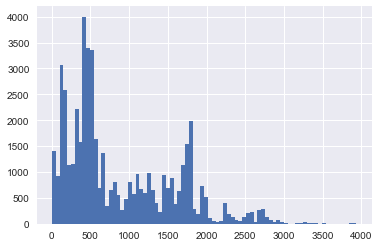

In [293]:
# Remove limit from the pipeline
pipeline = [{"$match": {"type": "way"}},
            {'$project': {'DiffMilliSec': {'$subtract': [datetime.now(), '$way.timestamp']}}}, 
            {'$project': {'_id': 1, 'AgeDays': {'$divide': ['$DiffMilliSec', 1000*60*60*24]}}}, 
            {"$sort": {"AgeDays": -1}}
           ]

results = agg_pipeline(sydney_db, pipeline)

# Create and populate dictionary
agedict = {}
for result in results: 
    agedict[result['_id']] = result['AgeDays']
    
# Import pandas DataFrame to create a dataframe and plot it
from pandas import DataFrame
# Create a dataframe with rows as keys
agedf = DataFrame.from_dict(agedict, orient='index')  

# Plot data 
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting a histogram
agedf[0].hist(bins = 80)

So, the information is not exactly fresh. In my opinion, records with age more than 1000 days (~ 3 years) should be revisited. 

# Conclusion

In this submission, I have downloaded information on several Sydney suburbs from openstreetmap in xml format, examined the data, came up with specific approaches to clean the data, performed wrangling and transformed it to json. Produced file was then imported to MongoDB, and additional data exploration was performed in the database. 

Below is the final wrap-up on approaches to clean the data, benefits, and anticipated issues: 

**1. Problematic payment tags cleaning** 

Payment tags with the key containing problematic characters and 'payment' in any case (lower or upper) are changed to a tag from the OpenStreetMap wiki "payment:credit_cards" with the value "yes". 

* Benefits
   1. Problematic characters are corrected for further processing. 
   2. A specific tag in the dataset is changed to reflect that payment by credit cards are accepted. 
   
   
* Anticipated issues
   1. Since the tags are processed to reflect payment:credit_cards=yes following up on the detection of a single case in the dataset, tags in incorrect format with other payment methods will have the same value. This may be incorrect - therefore, the process_bad_payment function should be improved if the code is used on other datasets. 
   
**2. Skipping tags with problematic characters without 'payment' in their key** 

* Benefits
   1. Problematic characters are corrected for further processing. 
   
   
* Anticipated issues
   1. Relevant tags with useful data could be skipped. The code should be changed if one wants to investigate tags with problematic characters on other datasets.  
   
**3. Cleaning street names according to the audit analysis** 

* Benefits
   1. Several universal transformations are performed to correct typical errors caused by manual input (cleaning non-English and non-alphanumeric symbols, removing clarifications, etc.). 
   2. Particular values are changed using knowledge of the reviewed area. 
   3. The process_st_name function is quite fast despite having a set of complex rules. It will take ~ 14 seconds to process a million records. 
   
   
* Anticipated issues
   1. The approach to clean street names may be irrelevant in other areas. I recommend checking the results of applying the process_st_name function to elements of a new dataset prior to using it. 
   2. If better performance is required, one could consider rewriting the function without using regular expressions. 
 
**4. Cleaning maximum speed values** 

* Benefits
   1. Several universal transformations performed to correct typical errors caused by manual input ('mph' in name, 'sign' to 'signals'). 
   2. The function is lightning fast (~ 3 seconds to process 10 million values). 
   
   
* Anticipated issues
   1. If a value cannot be transformed to integer after removing 'mph', None will be returned (except for values '10;10', 'sign', and 'signals'. Auditing of values in a new dataset is recommended to modify the process_speed function if required. 
   
**5. Cleaning cycling-related tags**

* Benefits
   1. Universal transformations performed to correct typical errors caused by manual input (removing problematic symbols, changing 'y' to 'yes', deleting a part after the first semicolon). 
   2. The function is fast (~ 3 seconds to process 1 million values). 
   
   
* Anticipated issues
   1. If a new dataset is used, there may be some unexpected tag values. I recommend auditing values of a new dataset to modify the process_bicycle function if required. 
   
Overally, the final process_map function took ~ 31 seconds to process the 68.83 Mb dataset and to produce 329552 records, which would be inappropriate for real-time use but satisfactory for an offline analysis. 